# Bibliotecas

In [ ]:
# Importando bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect, text
import seaborn as sns

# Dados

### Dados

In [ ]:
# Definindo os dados
url_itens_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/itens_pedidos.csv'
url_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/pedidos.csv'
url_produto = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/produtos.csv'
url_vendedores = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/vendedores.csv'

In [ ]:
# Importando os dados
itens_pedidos = pd.read_csv(url_itens_pedidos)
pedidos = pd.read_csv(url_pedidos)
produtos = pd.read_csv(url_produto)
vendedores = pd.read_csv(url_vendedores)

### Dicionário de dados

**Tabela vendedores**

`nome_vendedor`	Nome do vendedor

`vendedor_id`	Identificador do vendedor

**Tabela itens pedidos**

`estado`	Estado para onde o pedido foi enviado

`frete`	Valor do frete cobrado para o envio do produto

`id_nf`	Identificador da nota fiscal do pedido

`pedido_id`	Identificador do pedido

`produto_id`	Identificador do produto

`quantidade`	Quantidade de pedidos

`valor_total`	Valor total dos pedidos

`valor_unitario`	Valor por unidade do pedido

**Tabela produto**

`condicao`	Condição do produto

`marca`	Marca do produto

`preco`	Preço do produto

`produto`	Nome do produto

`produto_id`	Identificador do produto

`sku`	Identificador do produto no estoque

`Total`	Número total de produtos

**Tabela pedido**

`data_compra`	Data de compra do pedido

`pedido_id`	Identificador do pedido

`produto_id`	Identificador do produto

`total`	Número total de pedidos

`vendedor_id`	Identificador do vendedor

# Alocando tabelas no SQLite

In [ ]:
# Criando banco de dados local
engine = create_engine('sqlite:///:memory:')

In [ ]:
# Adicionando as tabelas no banco de dados
produtos.to_sql('produtos', engine, index=False)
itens_pedidos.to_sql('itens_pedidos', engine, index=False)
pedidos.to_sql('pedidos', engine, index=False)
vendedores.to_sql('vendedores', engine, index=False)

5

In [ ]:
# Inspecionando se todas as tabelas foram adicionadas ao banco de dados
inspector = inspect(engine)
print(inspector.get_table_names())

['itens_pedidos', 'pedidos', 'produtos', 'vendedores']


# Consultas

### Condição dos produtos

In [ ]:
# Consulta
query = 'SELECT CONDICAO FROM PRODUTOS'

In [ ]:
# Execução da consulta
with engine.connect() as conexao:
    consulta = conexao.execute(text(query))
    dados = consulta.fetchall()
pd.DataFrame(dados, columns=consulta.keys())

,Condicao
0,Usado
1,Usado
2,Usado
3,Usado
4,Usado
...,...
200,Usado
201,Usado
202,Usado
203,Usado


In [ ]:
# Criando função para realizar consultas sql
def sql_df(query):
    with engine.connect() as conexao:
        consulta = conexao.execute(text(query))
        dados = consulta.fetchall()
    return pd.DataFrame(dados, columns=consulta.keys())

In [ ]:
query = '''
SELECT CONDICAO, COUNT(*) AS 'Quantidade'
FROM PRODUTOS
GROUP BY CONDICAO
ORDER BY Quantidade;
'''
df_produtos = sql_df(query)
df_produtos

,Condicao,Quantidade
0,Novo sem etiqueta,7
1,Novo com etiqueta,22
2,Usado,176


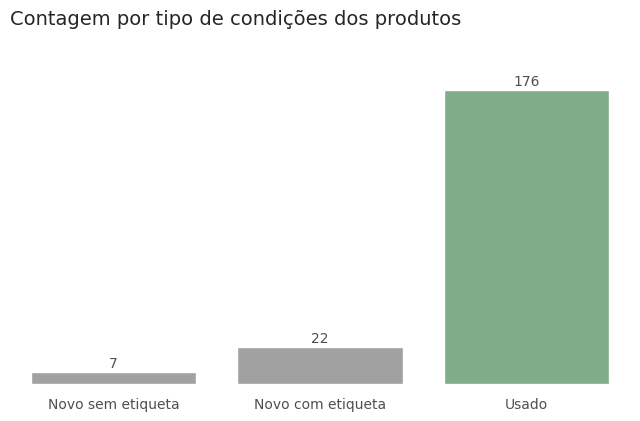

In [ ]:
cores = []
max_qtd  = df_produtos['Quantidade'].max()

for qtd in df_produtos['Quantidade']:
    if qtd == max_qtd:
        cores.append('#76B583')
    else:
        cores.append('#A1A1A1')

fig, ax = plt.subplots(figsize=(8,4))
sns.set_theme(style='white')

ax = sns.barplot(data=df_produtos,
                 x='Condicao',
                 y='Quantidade',
                 hue='Condicao',
                 legend=False,
                 palette=cores)
plt.title('Contagem por tipo de condições dos produtos',
          fontsize=14,
          loc='left',
          pad=15,
          y=1.1)
ax.set_xlabel('')
ax.set_ylabel('')
ax.yaxis.set_ticks([])
ax.xaxis.set_tick_params(labelsize=10, labelcolor='#4F4F4F')
sns.despine(bottom=True, left=True)

for i, valor in enumerate(df_produtos['Quantidade']):
    qtd = valor
    offset = max(df_produtos['Quantidade']) * 0.03
    ax.text(y=valor + offset, x=i, s=qtd, color='#4F4F4F', fontsize=10, ha='center', va='center')

plt.show()

### Relacionando tabelas

In [ ]:
sql_df('SELECT * FROM PRODUTOS').head(3)

,produto_id,produto,preco,marca,sku,Condicao
0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297,Usado
1,9981,Bolsa Coral Saco,4000,Givenchy,278612,Usado
2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482,Usado


In [ ]:
sql_df('SELECT * FROM ITENS_PEDIDOS').head(3)

,id_nf,produto_id,pedido_id,quantidade,valor_unitario,valor_total,Estado,frete
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0


In [ ]:
query = '''
SELECT PRODUTOS.PRODUTO, SUM(ITENS_PEDIDOS.QUANTIDADE) AS quantidade
FROM ITENS_PEDIDOS, PRODUTOS
WHERE ITENS_PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
GROUP BY PRODUTOS.PRODUTO
ORDER BY quantidade DESC
LIMIT 10
'''
top_10_vendas = sql_df(query)
top_10_vendas

,produto,quantidade
0,Vestido Recortes Cores,795
1,Calca Jeans Costuras,755
2,Saia Pregas Preta,751
3,Calca Alfaiataria Preta,750
4,Saia Midi Cinto,549
5,Vestido Nude Reta,547
6,Blusa Manga Estampa,536
7,Camisa Xadrez Azul,511
8,Cropped Escritas Pb,508
9,Bomber Tricot Off,507


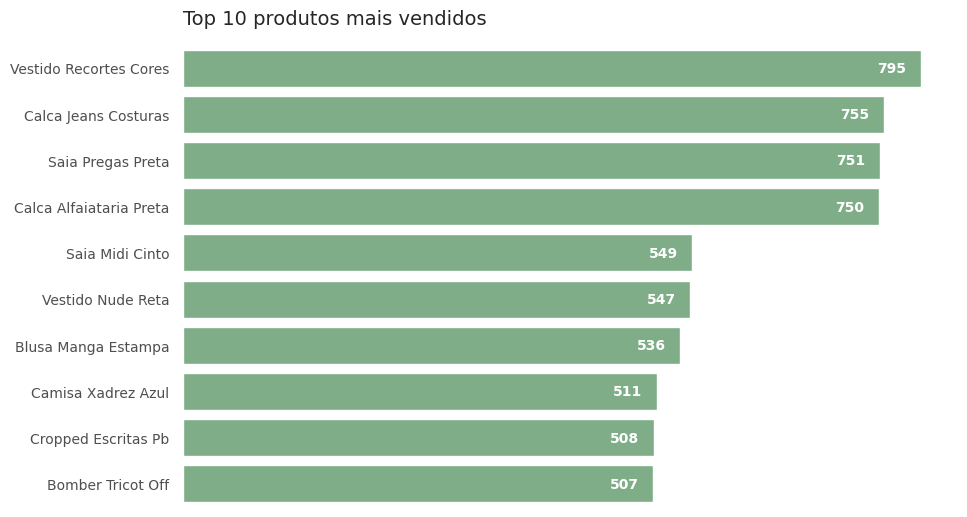

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.set_theme(style='white')

ax = sns.barplot(data=top_10_vendas,
                 x='quantidade',
                 y='produto',
                 color='#76B583')
plt.title('Top 10 produtos mais vendidos',
          fontsize=14,
          loc='left',
          pad=15)
ax.set_xlabel('')
ax.set_ylabel('')
ax.xaxis.set_ticks([])
ax.xaxis.set_tick_params(labelsize=10, labelcolor='#4F4F4F')
ax.yaxis.set_tick_params(labelsize=10, labelcolor='#4F4F4F')
sns.despine(bottom=True, left=True)

for i, valor in enumerate(top_10_vendas['quantidade']):
    qtd = valor
    offset = max(top_10_vendas['quantidade']) * 0.02
    ax.text(valor - offset, i, qtd, color='white', fontsize=10, fontweight='bold', ha='right', va='center')

plt.show()

### Análises propostas

Calcular a receita total obtida com a venda de itens.

In [ ]:
sql_df('SELECT * FROM ITENS_PEDIDOS').head(3)

,id_nf,produto_id,pedido_id,quantidade,valor_unitario,valor_total,Estado,frete
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0


In [ ]:
sql_df('SELECT * FROM PRODUTOS').head(3)

,produto_id,produto,preco,marca,sku,Condicao
0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297,Usado
1,9981,Bolsa Coral Saco,4000,Givenchy,278612,Usado
2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482,Usado


In [ ]:
df_itens_pedidos = sql_df('SELECT VALOR_TOTAL FROM ITENS_PEDIDOS')
receita_total = df_itens_pedidos['valor_total'].sum()
print(f'Receita total das vendas: R$ {receita_total:.2f}')

Receita total das vendas: R$ 45803930.00


In [ ]:
# Mesma análise, utilizando função SUM() do SQL
query = '''
SELECT SUM(VALOR_TOTAL) AS Receita
FROM ITENS_PEDIDOS
'''
df_itens_pedidos = sql_df(query)
df_itens_pedidos

,Receita
0,45803930


Identificar quais as 15 marcas que foram as mais pedidas por quantidades de venda.

In [ ]:
query = '''
SELECT PRODUTOS.MARCA, SUM(ITENS_PEDIDOS.QUANTIDADE) AS quantidade
FROM PRODUTOS, ITENS_PEDIDOS
WHERE PRODUTOS.PRODUTO_ID = ITENS_PEDIDOS.PRODUTO_ID
GROUP BY PRODUTOS.MARCA
ORDER BY Quantidade DESC
LIMIT 15
'''
top_15_marcas = sql_df(query)
top_15_marcas

,marca,quantidade
0,Zara,9545
1,Mixed,5748
2,Animale,4013
3,Le Lis Blanc,2479
4,Banana Republic,2045
5,Farm,1779
6,H&m,1576
7,Shoulder,1317
8,Sacada,1285
9,Dress&co,1262


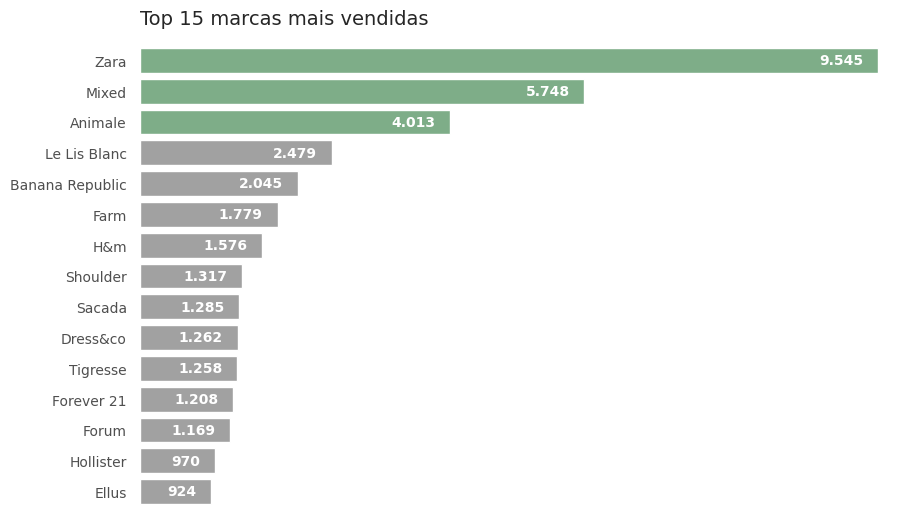

In [ ]:
cores = ['#76B583' if x < 3 else '#A1A1A1' for x in range(15)]

fig, ax = plt.subplots(figsize=(10,6))
sns.set_theme(style='white')

ax = sns.barplot(data=top_15_marcas,
                 x='quantidade',
                 y='marca',
                 hue='marca',
                 legend=False,
                 palette=cores)
plt.title('Top 15 marcas mais vendidas',
          fontsize=14,
          loc='left',
          pad=15)
ax.set_xlabel('')
ax.xaxis.set_ticks([])
ax.set_ylabel('')
ax.xaxis.set_tick_params(labelsize=10, labelcolor='#4F4F4F')
ax.yaxis.set_tick_params(labelsize=10, labelcolor='#4F4F4F')
sns.despine(bottom=True, left=True)

for i, valor in enumerate(top_15_marcas['quantidade']):
    qtd = f'{valor:,.0f}'.replace(',','.')
    offset = max(top_15_marcas['quantidade']) * 0.02
    ax.text(valor - offset, i, qtd, color='white', fontsize=10, fontweight='bold', ha='right', va='center')

plt.show()

### Filtros

In [ ]:
sql_df('SELECT * FROM PEDIDOS').head(3)

,pedido_id,produto_id,vendedor_id,data_compra,total
0,341,41518,5,2019-01-05,780
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600


In [ ]:
sql_df('SELECT * FROM PEDIDOS').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   pedido_id    24527 non-null  int64 
 1   produto_id   24527 non-null  int64 
 2   vendedor_id  24527 non-null  int64 
 3   data_compra  24527 non-null  object
 4   total        24527 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 958.2+ KB


In [ ]:
# Consulta vendas por vendedor no ano de 2020
query = '''
SELECT VENDEDORES.NOME_VENDEDOR, COUNT(PEDIDOS.PEDIDO_ID) AS 'Quantidade vendas'
FROM VENDEDORES, PEDIDOS
WHERE strftime('%Y', data_compra) = '2020' AND VENDEDORES.VENDEDOR_ID = PEDIDOS.VENDEDOR_ID
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY COUNT(PEDIDOS.PEDIDO_ID) DESC;
'''
sql_df(query)

,nome_vendedor,Quantidade vendas
0,Ana Duarte,3427
1,Daniel Siqueira,3338
2,Nadia Oliveira,2782
3,Millena Pereira,2510
4,Paulo Calanca,2488


In [ ]:
# Consulta valor médio por vendas de cada vendedor no ano de 2020
query = '''
SELECT VENDEDORES.NOME_VENDEDOR, AVG(PEDIDOS.TOTAL) AS 'Valor médio por vendas'
FROM VENDEDORES, PEDIDOS
WHERE strftime('%Y', data_compra) = '2020' AND VENDEDORES.VENDEDOR_ID = PEDIDOS.VENDEDOR_ID
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY AVG(PEDIDOS.TOTAL) DESC;
'''
sql_df(query)

,nome_vendedor,Valor médio por vendas
0,Daniel Siqueira,1972.338526
1,Millena Pereira,1894.614343
2,Ana Duarte,1843.452582
3,Nadia Oliveira,1818.342200
4,Paulo Calanca,1813.469855


### Análises propostas

Exibir os 10 produtos mais vendidos durante o ano de 2019

In [ ]:
sql_df('SELECT * FROM PEDIDOS').head(3)

,pedido_id,produto_id,vendedor_id,data_compra,total
0,341,41518,5,2019-01-05,780
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600


In [ ]:
sql_df('SELECT * FROM PRODUTOS').head(3)

,produto_id,produto,preco,marca,sku,Condicao
0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297,Usado
1,9981,Bolsa Coral Saco,4000,Givenchy,278612,Usado
2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482,Usado


In [ ]:
query = '''
SELECT PRODUTOS.PRODUTO, COUNT(PEDIDOS.PEDIDO_ID) AS 'Quantidade vendida'
FROM PRODUTOS, PEDIDOS
WHERE strftime('%Y', data_compra) = '2019' AND PRODUTOS.PRODUTO_ID = PEDIDOS.PRODUTO_ID
GROUP BY PRODUTOS.PRODUTO
ORDER BY COUNT(PEDIDOS.PEDIDO_ID) DESC
LIMIT 10;
'''
mais_vendidos_2019 = sql_df(query)
mais_vendidos_2019

,produto,Quantidade vendida
0,Vestido Recortes Cores,85
1,Calca Jeans Costuras,81
2,Saia Pregas Preta,73
3,Calca Alfaiataria Preta,66
4,Camisa Xadrez Azul,60
5,Bomber Tricot Off,56
6,Shorts Bordado Branco,55
7,Blusa Manga Estampa,54
8,Saia Midi Cinto,53
9,Saia Evase Cinza,53


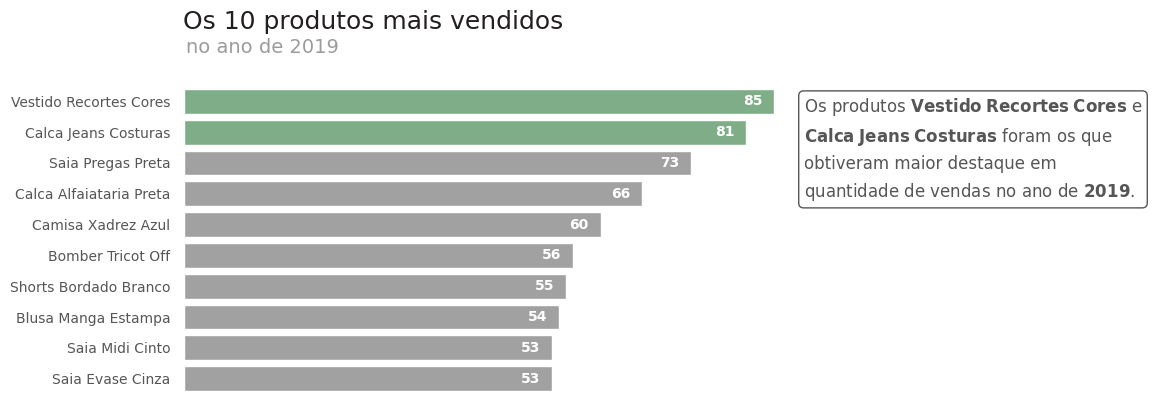

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
sns.set_theme(style='white')

cores = ['#76B583' if x < 2 else '#A1A1A1' for x in range(10)]

ax = sns.barplot(data=mais_vendidos_2019,
                 x='Quantidade vendida',
                 y='produto',
                 hue='produto',
                 legend=False,
                 palette=cores)
plt.suptitle('Os 10 produtos mais vendidos',
             fontsize=18,
             color='#231F20',
             ha='right',
             x=0.6,
             y=1.07)
plt.title('no ano de 2019',
          fontsize=14,
          loc='right',
          color='#9C9C9C',
          pad=15,
          x=0.25,
          y=1.04)
ax.set_xlabel('')
ax.xaxis.set_ticks([])
ax.set_ylabel('')
ax.xaxis.set_tick_params(labelsize=10, labelcolor='#555655')
ax.yaxis.set_tick_params(labelsize=10, labelcolor='#555655')
sns.despine(bottom=True, left=True)

for i, valor in enumerate(mais_vendidos_2019['Quantidade vendida']):
    qtd = f'{valor:,.0f}'.replace(',','.')
    offset = max(mais_vendidos_2019['Quantidade vendida']) * 0.02
    ax.text(valor - offset, i, qtd, color='white', fontsize=10, fontweight='bold', ha='right', va='center')

ax.text(1.0, 0.64,
        'Os produtos $\\bf{Vestido\\;Recortes\\;Cores}$ e\n'
        '$\\bf{Calca\\;Jeans\\;Costuras}$ foram os que\n'
        'obtiveram maior destaque em\n'
        'quantidade de vendas no ano de $\\bf{2019}$.',
        fontsize=12,
        linespacing=1.5,
        color='#555655',
        bbox=dict(boxstyle="round", fc='#FFFFFF', ec='#555655'),
        transform=ax.transAxes)

plt.show()

Publicar a distribuição através dos meses da receita obtida em vendas no ano de 2020

In [ ]:
sql_df('SELECT * FROM PEDIDOS').head(3)

,pedido_id,produto_id,vendedor_id,data_compra,total
0,341,41518,5,2019-01-05,780
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600


In [ ]:
sql_df('SELECT * FROM ITENS_PEDIDOS').head(3)

,id_nf,produto_id,pedido_id,quantidade,valor_unitario,valor_total,Estado,frete
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0


In [ ]:
query = '''
SELECT strftime('%m', data_compra) AS mes, SUM(TOTAL) AS receita
FROM PEDIDOS
WHERE strftime('%Y', data_compra) = '2020'
GROUP BY mes;
'''
receita_2020 = sql_df(query)
receita_2020

,mes,receita
0,01,2458252
1,02,2168386
2,03,2472297
3,04,2189559
4,05,2168099
5,06,1577791
6,07,1881010
7,08,2268550
8,09,2428227
9,10,2079915


In [ ]:
meses = {'01':'Jan', '02':'Fev', '03':'Mar', '04':'Abr', '05':'Mai', '06':'Jun',
         '07':'Jul', '08':'Ago', '09':'Set', '10':'Out', '11':'Nov', '12':'Dez'}

receita_2020['mes'] = receita_2020['mes'].map(meses)
receita_2020

,mes,receita
0,Jan,2458252
1,Fev,2168386
2,Mar,2472297
3,Abr,2189559
4,Mai,2168099
5,Jun,1577791
6,Jul,1881010
7,Ago,2268550
8,Set,2428227
9,Out,2079915


In [ ]:
receita_2020['receita'] = round(receita_2020['receita']/1e6, 2)
receita_2020

,mes,receita
0,Jan,2.46
1,Fev,2.17
2,Mar,2.47
3,Abr,2.19
4,Mai,2.17
5,Jun,1.58
6,Jul,1.88
7,Ago,2.27
8,Set,2.43
9,Out,2.08


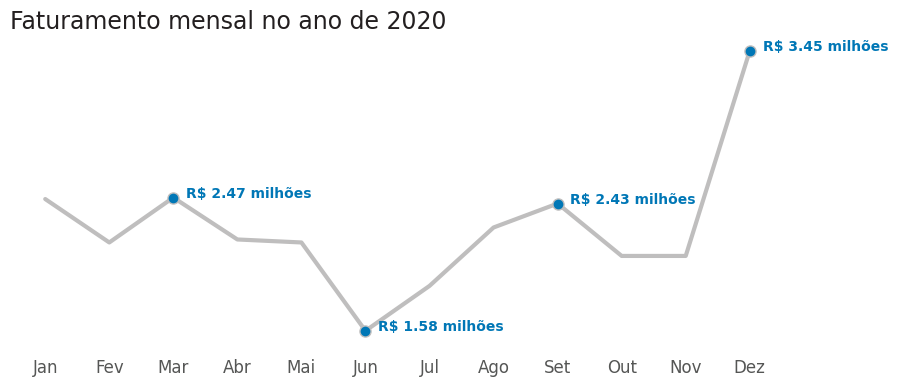

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
sns.set_theme(style='white')

ax.plot(receita_2020['mes'], receita_2020['receita'], lw=3, color='#BFBEBE',
        marker='o', markersize=8, markerfacecolor='#0077b6', markevery=(2,3))
ax.set_title('Faturamento mensal no ano de 2020',
             fontsize=17, color='#231F20', loc='left')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels([])
ax.xaxis.set_tick_params(labelsize=12, labelcolor='#555655')
ax.set_frame_on(False)

for i in range(2, len(receita_2020['receita']), 3):
    ax.text(x=ax.get_xticks()[i] + 0.2, y=receita_2020['receita'][i],
            s=f'R$ {receita_2020['receita'][i]} milhões', color='#0077b6',
            weight='bold', fontsize=10)

plt.show()

### Relacionamentos

In [ ]:
query = '''
SELECT ESTADO, COUNT(*) AS Pedidos
FROM ITENS_PEDIDOS
GROUP BY ESTADO
ORDER BY Pedidos DESC;
'''
sql_df(query)

,Estado,Pedidos
0,BR-MA,974
1,BR-DF,953
2,BR-MT,937
3,BR-GO,933
4,BR-PA,932
5,BR-AL,928
6,BR-PE,927
7,BR-RR,925
8,BR-RO,925
9,BR-RN,921


In [ ]:
query = '''
SELECT VENDEDORES.NOME_VENDEDOR, COUNT(*) AS quantidade_vendas
FROM PEDIDOS
JOIN VENDEDORES ON VENDEDORES.VENDEDOR_ID = PEDIDOS.VENDEDOR_ID
JOIN ITENS_PEDIDOS ON ITENS_PEDIDOS.PEDIDO_ID = PEDIDOS.PEDIDO_ID
WHERE ITENS_PEDIDOS.ESTADO = 'BR-SP'
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY quantidade_vendas DESC;
'''
sql_df(query)

,nome_vendedor,quantidade_vendas
0,Daniel Siqueira,190
1,Paulo Calanca,182
2,Nadia Oliveira,181
3,Ana Duarte,180
4,Millena Pereira,157


### Análises propostas

Listar as marcas vendidas em São Paulo por quantidade de pedidos, que podem ser representadas em uma tabela

In [ ]:
query = '''
SELECT PRODUTOS.MARCA, COUNT(*) AS quantidade_vendida
FROM PRODUTOS
JOIN ITENS_PEDIDOS ON ITENS_PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
WHERE ITENS_PEDIDOS.ESTADO = 'BR-SP'
GROUP BY PRODUTOS.MARCA
ORDER BY quantidade_vendida DESC;
'''
marcas_sp = sql_df(query)
marcas_sp

,marca,quantidade_vendida
0,Zara,100
1,Mixed,58
2,Animale,44
3,Le Lis Blanc,26
4,Banana Republic,18
...,...,...
111,Topshop,1
112,Morena Rosa,1
113,Erre Erre,1
114,Bobô,1


Publicar os produtos que são mais vendidos na época de Natal no Brasil todo

In [ ]:
query = '''
SELECT PRODUTOS.PRODUTO, COUNT(*) AS quantidade_vendida
FROM ITENS_PEDIDOS
JOIN PRODUTOS ON PRODUTOS.PRODUTO_ID = ITENS_PEDIDOS.PRODUTO_ID
JOIN PEDIDOS ON PEDIDOS.PEDIDO_ID = ITENS_PEDIDOS.PEDIDO_ID
WHERE strftime('%m', PEDIDOS.data_compra) = '12'
GROUP BY PRODUTOS.PRODUTO
ORDER BY quantidade_vendida DESC;
'''
produtos_dez = sql_df(query)
produtos_dez

,produto,quantidade_vendida
0,Vestido Recortes Cores,30
1,Vestido Preto Franzido,26
2,Calca Jeans Costuras,26
3,Calca Alfaiataria Preta,26
4,Camisa Xadrez Azul,25
...,...,...
196,Sneaker Monograma Bege,6
197,Casaqueto Estampa Geometrica,6
198,Regata Renda Branca,5
199,Body Estampa Coracoes,5
